In [82]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import deepcopy
import sunpy
import sunpy.map
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
import cv2
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sunkit_image import coalignment
from sun_blinker import SunBlinker

In [2]:
with fits.open("../../src/CHASE/20221025/RSM20221025T185526_0022_HA.fits") as hdul:
    hdul.info()
    chase_halpha_data = hdul[1].data[:]
    chase_header = deepcopy(hdul[1].header)

Filename: ../../src/CHASE/20221025/RSM20221025T185526_0022_HA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU     48   (2304, 2313, 118)   int16   


In [3]:
chase_halpha_data.shape

(118, 2313, 2304)

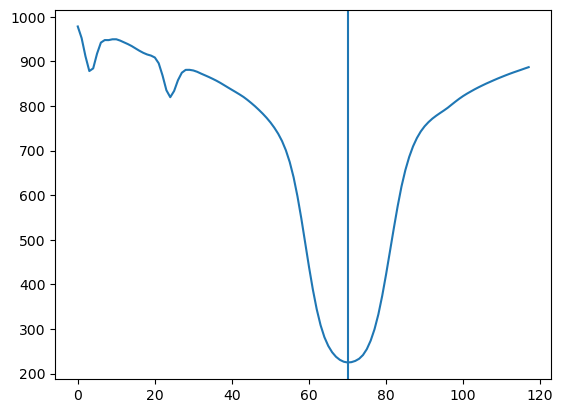

In [3]:
sample_spec = np.nanmean(chase_halpha_data[:, :, :], axis=(1, 2))
plt.plot(sample_spec)
plt.axvline(70)

In [50]:
img_line_core = np.nanmean(chase_halpha_data[68:73, :, :], axis=0)
img_line_core_8bit = cv2.normalize(src=img_line_core, dst=None, alpha=0, beta=255,
                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

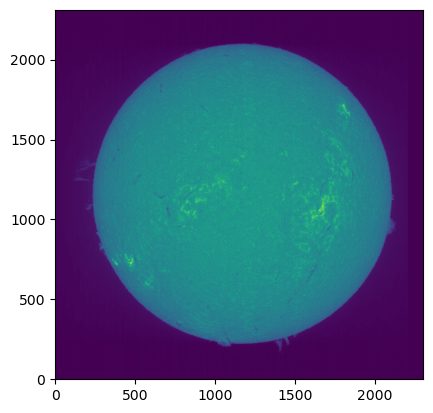

In [5]:
plt.imshow(img_line_core_8bit, origin='lower')

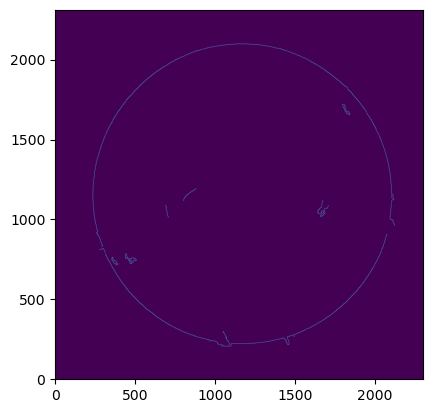

In [51]:
img_edges = canny(img_line_core_8bit, sigma=3, low_threshold=10, high_threshold=50)
plt.imshow(img_edges, origin='lower')

In [10]:
hough_res = hough_circle(img_edges, radius=924)
accums, cx, cy, radii = hough_circle_peaks(hough_res, [924], total_num_peaks=1)

In [11]:
cx, cy

(array([1168]), array([1144]))

In [17]:
chase_fits_header = sunpy.map.make_fitswcs_header(chase_halpha_data[0,:,:].shape,
                                                  SkyCoord(chase_header["CRVAL1"]*u.arcsec,chase_header["CRVAL2"]*u.arcsec,
                                                           obstime=chase_header["DATE_OBS"],observer="Earth",frame="helioprojective",
                                                           rsun=696000000.0*u.m),
                                                  reference_pixel=[cx[0],cy[0]]*u.pix,
                                                  scale=u.Quantity([chase_header["CDELT1"],chase_header["CDELT2"]],u.arcsec/u.pix),
                                                  rotation_angle=-chase_header["INST_ROT"]*u.deg,
                                                  telescope="CHASE",instrument="RSM")

In [52]:
chase_line_core_map = sunpy.map.Map(img_line_core, chase_fits_header)
chase_line_core_map = chase_line_core_map.rotate()

(<matplotlib.patches.Circle at 0x7ffa012b31a0>, None)

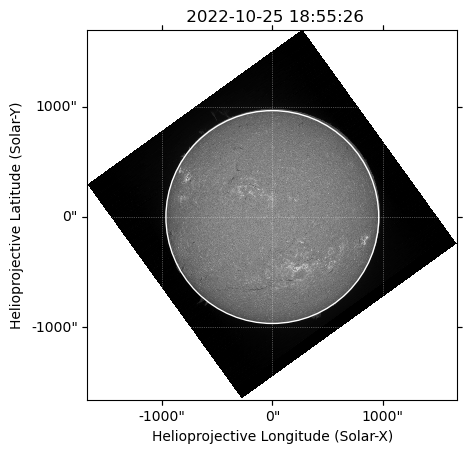

In [53]:
chase_line_core_map.plot()
chase_line_core_map.draw_limb()

In [23]:
def find_line_width(wvl,spec, line_core_slice = np.s_[62:77], line_slice = np.s_[50:87]):
    if spec[-1] < 100:
        return np.nan
    else:
        line_core_fit_param = np.polyfit(wvl[line_core_slice], spec[line_core_slice], 2)
        line_core_fit = np.poly1d(line_core_fit_param)

        line_cen = - line_core_fit_param[1] / (2 * line_core_fit_param[0])
        line_min = line_core_fit_param[2] - line_core_fit_param[1]**2/(4*line_core_fit_param[0])
        
        line_wing_int = (np.interp(line_cen - 1., wvl, spec) + \
                        np.interp(line_cen + 1., wvl, spec)) / 2
        
        half_int = (line_min + line_wing_int) / 2

        line_width =  np.interp(half_int, spec[line_core_slice.stop:line_slice.stop], wvl[line_core_slice.stop:line_slice.stop])- \
                        np.interp(half_int, np.flip(spec[line_slice.start:line_core_slice.start]), np.flip(wvl[line_slice.start:line_core_slice.start]))
        return line_width

In [24]:
chase_wavelength = (np.arange(chase_header["NAXIS3"]) + 1 - (chase_header["CRPIX3"] + 1))*chase_header["CDELT3"] + chase_header["CRVAL3"]

In [25]:
chase_halpha_data_flat = chase_halpha_data.reshape(chase_halpha_data.shape[0], -1)
chase_halpha_line_width = np.zeros(chase_halpha_data_flat.shape[1])
for ii in range(chase_halpha_data_flat.shape[1]):
    chase_halpha_line_width[ii] = find_line_width(chase_wavelength, chase_halpha_data_flat[:,ii])
chase_halpha_line_width = chase_halpha_line_width.reshape(chase_halpha_data.shape[1:])

In [26]:
chase_line_width_map = sunpy.map.Map(chase_halpha_line_width, chase_fits_header)
chase_line_width_map = chase_line_width_map.rotate()

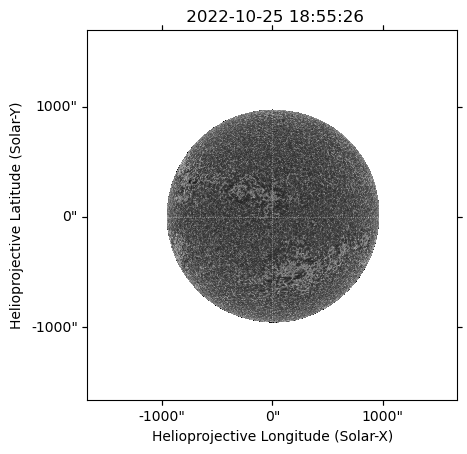

In [27]:
chase_line_width_map.plot()

In [30]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

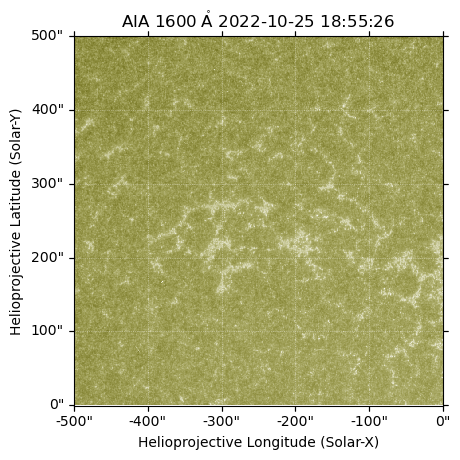

In [29]:
aia_1600_map = sunpy.map.Map("../../src/AIA/20221025/1600/lvl15/aia.lev1_uv_24s.2022-10-25T185527Z.1600.image.fits")
aia_1600_map_crop = aia_1600_map.submap(SkyCoord(-500*u.arcsec, 0*u.arcsec, frame=aia_1600_map.coordinate_frame),
                                        top_right=SkyCoord(0*u.arcsec, 500*u.arcsec, frame=aia_1600_map.coordinate_frame))
aia_1600_map_crop.plot()

In [40]:
aia_1600_map_crop_resampled = aia_1600_map_crop.resample(u.Quantity([aia_1600_map_crop.dimensions[0]*aia_1600_map_crop.scale[0]/chase_line_core_map.scale[0],
                                                          aia_1600_map_crop.dimensions[1]*aia_1600_map_crop.scale[1]/chase_line_core_map.scale[1]]))

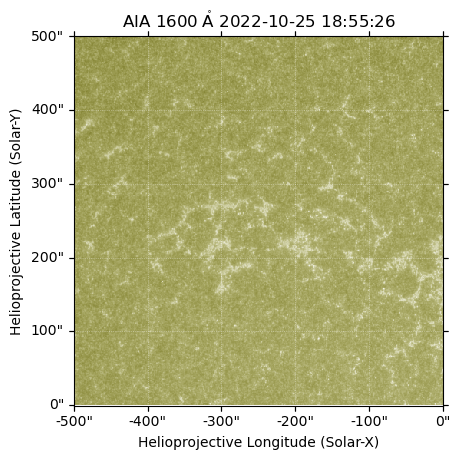

In [58]:
aia_1600_map_crop_resampled.plot()

In [72]:
chase_line_width_map_crop = chase_line_width_map.submap(SkyCoord(-400*u.arcsec, 100*u.arcsec, frame=chase_line_width_map.coordinate_frame),
                                                        top_right=SkyCoord(-100*u.arcsec, 400*u.arcsec, frame=chase_line_width_map.coordinate_frame))

In [74]:
chase_line_core_map_crop = chase_line_core_map.submap(SkyCoord(-400*u.arcsec, 100*u.arcsec, frame=chase_line_core_map.coordinate_frame),
                                                        top_right=SkyCoord(-100*u.arcsec, 400*u.arcsec, frame=chase_line_core_map.coordinate_frame))

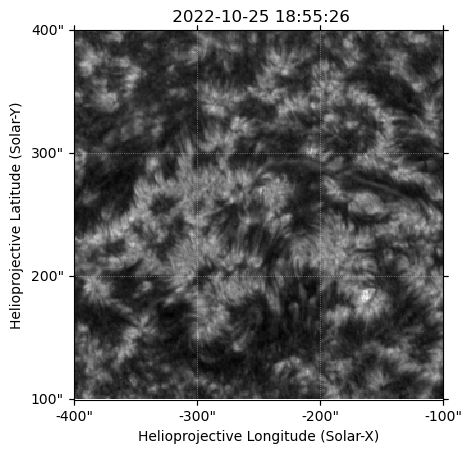

In [75]:
chase_line_width_map_crop.plot()

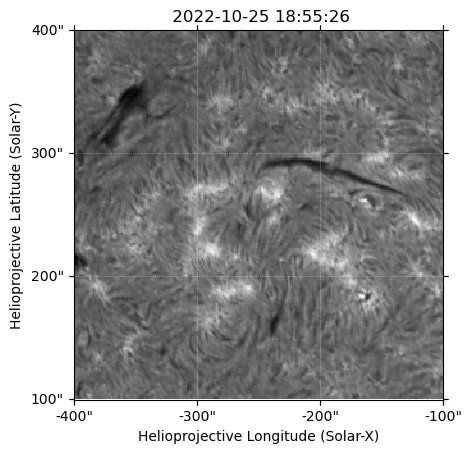

In [76]:
chase_line_core_map_crop.plot()

In [79]:
Txshift, Tyshift = coalign_shift(aia_1600_map_crop_resampled, chase_line_width_map_crop)
Txshift, Tyshift

(<Angle -4.82898116 arcsec>, <Angle -2.32773386 arcsec>)

In [81]:
chase_line_width_map_crop_shifted = chase_line_width_map_crop.shift_reference_coord(Txshift, Tyshift)
chase_line_width_map_shifted = chase_line_width_map.shift_reference_coord(Txshift, Tyshift)

In [83]:
SunBlinker(chase_line_width_map_crop_shifted, aia_1600_map_crop, reproject=True)

In [84]:
chase_line_width_map_shifted.save("../../src/coalign_map/20221025/chase_haplha_line_width.fits", overwrite=True)